# МатСтат. Практика 3.1
## Критерий согласия Пирсона (хи-квадрат)

В папке 6 файлов с данными. Данные имеют различные распределения:
- 1 и 4 файлы - нормальное распределение;
- 2 и 5 файлы - равномерное распределение;
- 3 и 6 файлы - показательное распределение.

Необходимо идентифицировать распределения в каждом файле двумя способами:
1. С помощью критерия согласия Пирсона;
2. Методом анаморфоз (excel-файлы в папке "прочее").

Методом Пирсона для каждого файла нужно проверить истинное распределение (то, к которому действительно относятся данные в файле, оно дано выше) и одное ложное.  
Например, если данные в файле распределены нормально, то нужно проверить нормальное распределение и одно из двух: показательное или равномерное.  
При расчете теоретических частот в качестве параметров распределений брать их точечные несмещенные оценки.
В отчет вставить гистограммы по каждому файлу, расчетные формулы и результаты проверки распределения.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
import matplotlib.pyplot as plt

In [2]:
def create_intervals(data, n):
    # количество интервалов
    S = int(1 + np.floor(np.log2(n)))
    data_intrvl = pd.cut(data.iloc[:, 0], bins=S)
    data[1] = data_intrvl
    return data, data_intrvl

In [3]:
def create_intrvl_brdrs(data_intrvl):
    intrvl_brdrs = []
    intervals = data_intrvl.value_counts().sort_index().index
    for i in range(intervals.size):
        intrvl_brdrs = np.append(intrvl_brdrs, intervals[i].left)
        
    intrvl_brdrs = np.append(intrvl_brdrs, intervals[intervals.size - 1].right)
    return intrvl_brdrs

In [4]:
def get_ni_norm(n, mj, std, intrvl_brdrs):
    #loc = мат. ожид., scale = ско
    p_i = np.zeros(intrvl_brdrs.size - 1)
    
    for i in range (intrvl_brdrs.size - 1):
        p_i[i] = sps.norm.cdf(intrvl_brdrs[i+1], mj, std) - sps.norm.cdf(intrvl_brdrs[i], mj, std)
    return n * p_i

In [5]:
def get_ni_uniform(n, mj, std, intrvl_brdrs):
    #loc = a, scale = b - a
    p_i = np.zeros(intrvl_brdrs.size - 1)
    b = np.sqrt(3) * std + mj
    a = 2 * mj - b
    
    for i in range (intrvl_brdrs.size - 1):
        p_i[i] = sps.uniform.cdf(intrvl_brdrs[i+1], a, b - a) - sps.uniform.cdf(intrvl_brdrs[i], a, b - a)
    return n * p_i

In [22]:
def get_ni_expon(n, mj, intrvl_brdrs):
    #loc = 0, scale = мат. ожид.
    p_i = np.zeros(intrvl_brdrs.size - 1)
    print('lam= ', 1/mj)
    
    for i in range (intrvl_brdrs.size - 1):
        p_i[i] = sps.expon.cdf(intrvl_brdrs[i+1], 0, mj) - sps.expon.cdf(intrvl_brdrs[i], 0, mj)
    return n * p_i

In [23]:
def get_chi_sqr(n_i, n_i_exp):
    return np.sum((n_i - n_i_exp)**2 / n_i_exp)

In [24]:
def draw_hist(n_i, n_i_exp, raspr, file):
    plt.figure(figsize =(8, 5))
    fig = n_i.plot(kind='bar')
    #fig.set_xticklabels(intrvl_brdrs[1:])
    plt.plot(n_i_exp, color='red')
    plt.title(raspr + ' распределение, файл ' + file)
    plt.grid();

In [25]:
def pearson_criterion(file, raspr, correct):
    alpha = 0.05
    data = pd.read_csv(file, header=None).sort_values(by=0, ignore_index=True)
    # количество всех измерений
    n = data.shape[0]
    
    data, data_intrvl = create_intervals(data, n)
    
    if (file == '4.txt') & (raspr == correct):
        n_i = data[1].value_counts().sort_index().iloc[:5]
    elif (file == '3.txt') & (raspr == correct):
        n_i = data[1].value_counts().sort_index().iloc[:5]  
    else:
        n_i = data[1].value_counts().sort_index()
        
    print('n_i:\n', n_i)
    
    mj = np.mean(data[0])
    std = np.std(data[0])
    print('mj =', np.round(mj, 2), '   std =', np.round(std, 2))
    intrvl_brdrs = create_intrvl_brdrs(data_intrvl)
    
    if raspr == 'norm':
        r = 2
        if file == '4.txt':
            n_i_exp = get_ni_norm(n, mj, std, intrvl_brdrs[:6])
        else:
            n_i_exp = get_ni_norm(n, mj, std, intrvl_brdrs)
    if raspr == 'uniform':
        r = 2
        n_i_exp = get_ni_uniform(n, mj, std, intrvl_brdrs)
    if raspr == 'expon':
        r = 1
        if file == '3.txt':
            n_i_exp = get_ni_expon(n, mj, intrvl_brdrs[:6])
        else:
            n_i_exp = get_ni_expon(n, mj, intrvl_brdrs)
        
    print('\nn_i ожидаемые:\n', n_i_exp)
    print('\nCHI_SQR = ', get_chi_sqr(n_i, n_i_exp))
    dgr_frdm = (intrvl_brdrs.size - 1) - r - 1
    print('dgr_freedom = ', dgr_frdm, ', alpha = ', alpha)
    
    if correct == raspr:
        draw_hist(n_i, n_i_exp, raspr, file)

### Критические значения:
#### chi_sqr при k=3, alpha=0.05 равен 7.8
#### chi_sqr при k=4, alpha=0.05 равен 9.5

Красной линией на графике обозначено ожидаемое распределение данных при заданных параметрах распределений.  
Графики нарисованы только при проверке распределения, которое совпадает с истинным в конкретном файле.

n_i:
 (-8.034, -2.359]     2
(-2.359, 3.283]      6
(3.283, 8.925]      11
(8.925, 14.567]      6
(14.567, 20.209]     3
(20.209, 25.851]     4
Name: 1, dtype: int64
mj = 8.67    std = 7.74

n_i ожидаемые:
 [1.97359534 5.31625135 8.63487014 8.43889572 4.96229726 1.75457755]

CHI_SQR =  5.090525010772785
dgr_freedom =  3 , alpha =  0.05


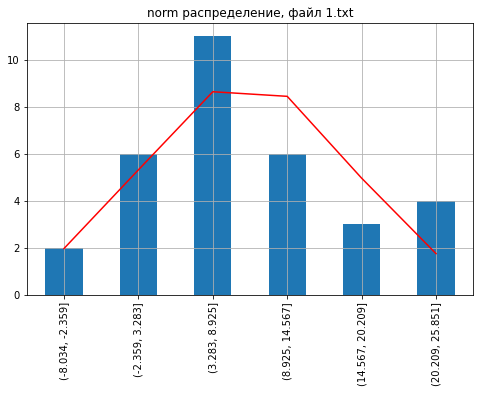

In [26]:
pearson_criterion(file='1.txt', raspr='norm', correct='norm')

In [27]:
pearson_criterion(file='1.txt', raspr='expon', correct='norm')

n_i:
 (-8.034, -2.359]     2
(-2.359, 3.283]      6
(3.283, 8.925]      11
(8.925, 14.567]      6
(14.567, 20.209]     3
(20.209, 25.851]     4
Name: 1, dtype: int64
mj = 8.67    std = 7.74
lam=  0.1153404687456509

n_i ожидаемые:
 [ 0.         10.08715173 10.48192536  5.46793732  2.85237086  1.4879504 ]

CHI_SQR =  inf
dgr_freedom =  4 , alpha =  0.05


n_i:
 (-6.365, -4.09]    7
(-4.09, -1.829]    4
(-1.829, 0.432]    8
(0.432, 2.693]     5
(2.693, 4.954]     4
(4.954, 7.215]     4
Name: 1, dtype: int64
mj = -0.12    std = 3.94

n_i ожидаемые:
 [5.33002188 5.29722174 5.29722174 5.29722174 5.29722174 4.12242196]

CHI_SQR =  2.557914937056692
dgr_freedom =  3 , alpha =  0.05


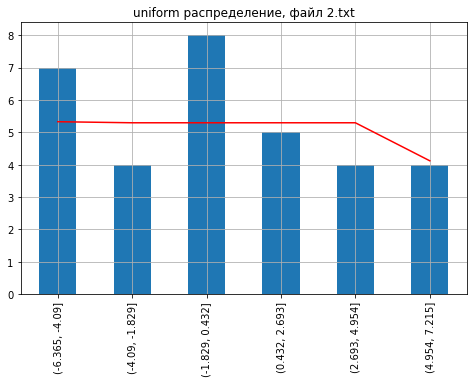

In [28]:
pearson_criterion(file='2.txt', raspr='uniform', correct='uniform')

In [29]:
pearson_criterion(file='2.txt', raspr='norm', correct='uniform')

n_i:
 (-6.365, -4.09]    7
(-4.09, -1.829]    4
(-1.829, 0.432]    8
(0.432, 2.693]     5
(2.693, 4.954]     4
(4.954, 7.215]     4
Name: 1, dtype: int64
mj = -0.12    std = 3.94

n_i ожидаемые:
 [3.20786615 5.60693402 7.14520756 6.61239994 4.44373725 2.16836631]

CHI_SQR =  7.030300385310912
dgr_freedom =  3 , alpha =  0.05


n_i:
 (0.0236, 1.136]    15
(1.136, 2.241]     11
(2.241, 3.347]      1
(3.347, 4.452]      2
(4.452, 5.558]      0
Name: 1, dtype: int64
mj = 1.61    std = 1.77
lam=  0.6221609853512182

n_i ожидаемые:
 [15.75014084  7.84692975  3.94821399  1.98282858  0.99766811]

CHI_SQR =  4.502010750859283
dgr_freedom =  4 , alpha =  0.05


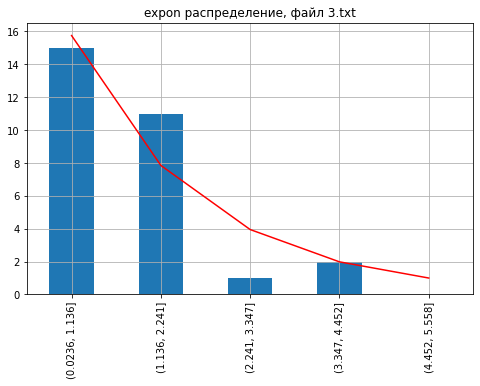

In [30]:
pearson_criterion(file='3.txt', raspr='expon', correct='expon')

In [31]:
pearson_criterion(file='3.txt', raspr='norm', correct='expon')

n_i:
 (0.0236, 1.136]    15
(1.136, 2.241]     11
(2.241, 3.347]      1
(3.347, 4.452]      2
(4.452, 5.558]      0
(5.558, 6.663]      3
Name: 1, dtype: int64
mj = 1.61    std = 1.77

n_i ожидаемые:
 [6.70028124 7.82489651 6.31027825 3.485004   1.32252625 0.34340171]

CHI_SQR =  38.54515017148968
dgr_freedom =  3 , alpha =  0.05


### Критические значения:
#### chi_sqr при k=3, alpha=0.05 равен 7.8
#### chi_sqr при k=4, alpha=0.05 равен 9.5
#### chi_sqr при k=5, alpha=0.05 равен 11.1
#### chi_sqr при k=6, alpha=0.05 равен 12.6


n_i:
 (-10.227, -7.058]    14
(-7.058, -3.914]     40
(-3.914, -0.77]      35
(-0.77, 2.374]       32
(2.374, 5.517]        5
Name: 1, dtype: int64
mj = -2.77    std = 3.84

n_i ожидаемые:
 [13.60779615 32.10887963 40.38202133 26.98256315  9.56831318]

CHI_SQR =  5.782041129172288
dgr_freedom =  5 , alpha =  0.05


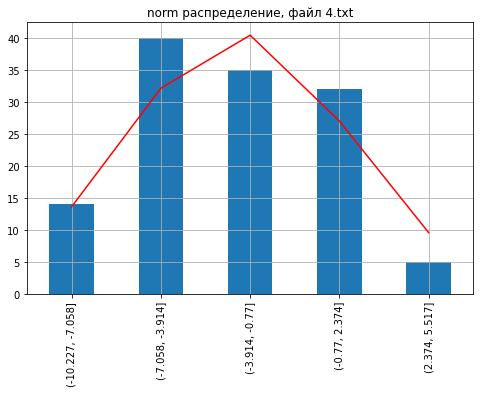

In [32]:
pearson_criterion(file='4.txt', raspr='norm', correct='norm')

In [33]:
pearson_criterion(file='4.txt', raspr='uniform', correct='norm')

n_i:
 (-10.227, -7.058]    14
(-7.058, -3.914]     40
(-3.914, -0.77]      35
(-0.77, 2.374]       32
(2.374, 5.517]        5
(5.517, 8.661]        1
(8.661, 11.805]       0
(11.805, 14.949]      1
Name: 1, dtype: int64
mj = -2.77    std = 3.84

n_i ожидаемые:
 [22.82913664 30.21691072 30.21691072 30.21691072 14.52013118  0.
  0.          0.        ]

CHI_SQR =  inf
dgr_freedom =  5 , alpha =  0.05


n_i:
 (-2.234, -1.424]    23
(-1.424, -0.621]    19
(-0.621, 0.183]     18
(0.183, 0.986]      16
(0.986, 1.79]       18
(1.79, 2.593]       10
(2.593, 3.397]       8
(3.397, 4.2]        16
Name: 1, dtype: int64
mj = 0.63    std = 1.91

n_i ожидаемые:
 [15.70975134 15.57398806 15.59338282 15.57398806 15.59338282 15.57398806
 15.59338282 10.28876129]

CHI_SQR =  13.754194183418718
dgr_freedom =  5 , alpha =  0.05


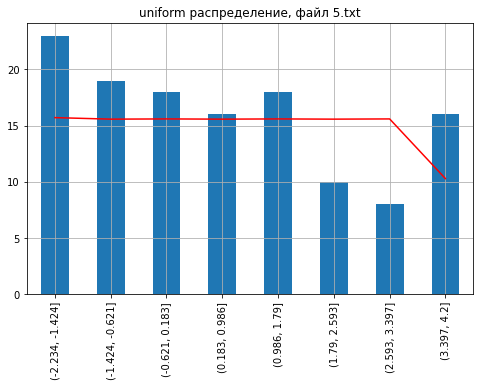

In [34]:
pearson_criterion(file='5.txt', raspr='uniform', correct='uniform')

In [35]:
pearson_criterion(file='5.txt', raspr='norm', correct='uniform')

n_i:
 (-2.234, -1.424]    23
(-1.424, -0.621]    19
(-0.621, 0.183]     18
(0.183, 0.986]      16
(0.986, 1.79]       18
(1.79, 2.593]       10
(2.593, 3.397]       8
(3.397, 4.2]        16
Name: 1, dtype: int64
mj = 0.63    std = 1.91

n_i ожидаемые:
 [ 9.50067021 14.76352789 19.40790451 21.35923656 19.77650089 15.32966789
  9.99715924  5.45763606]

CHI_SQR =  44.61936448928251
dgr_freedom =  5 , alpha =  0.05


n_i:
 (-0.00953, 1.4]    52
(1.4, 2.797]       37
(2.797, 4.195]     18
(4.195, 5.593]      8
(5.593, 6.991]      4
(6.991, 8.389]      3
(8.389, 9.787]      5
(9.787, 11.184]     1
Name: 1, dtype: int64
mj = 2.43    std = 2.35
lam=  0.4116115438877456

n_i ожидаемые:
 [56.06419655 31.45803988 17.71058785  9.96152035  5.60296974  3.15145367
  1.77257074  0.9964748 ]

CHI_SQR =  8.004188993192836
dgr_freedom =  6 , alpha =  0.05


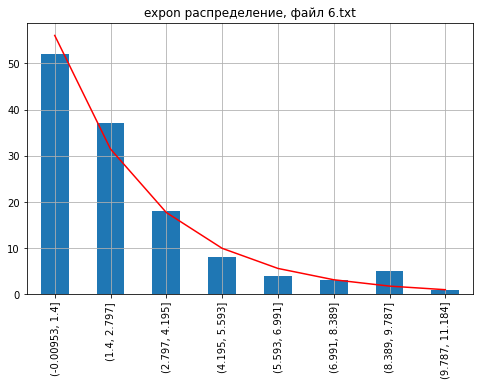

In [36]:
pearson_criterion(file='6.txt', raspr='expon', correct='expon')

In [37]:
pearson_criterion(file='6.txt', raspr='uniform', correct='expon')

n_i:
 (-0.00953, 1.4]    52
(1.4, 2.797]       37
(2.797, 4.195]     18
(4.195, 5.593]      8
(5.593, 6.991]      4
(6.991, 8.389]      3
(8.389, 9.787]      5
(9.787, 11.184]     1
Name: 1, dtype: int64
mj = 2.43    std = 2.35

n_i ожидаемые:
 [22.16644446 21.96939612 21.98512225 21.98512225 14.25001325  0.
  0.          0.        ]

CHI_SQR =  inf
dgr_freedom =  5 , alpha =  0.05


### Критические значения:
#### chi_sqr при k=5, alpha=0.05 равен 11.1
#### chi_sqr при k=6, alpha=0.05 равен 12.6